In [5]:
%load_ext autoreload
%autoreload 2
import os
import sys
import matplotlib.pyplot as plt
from torchvision.transforms import v2
import torch
from torch.utils.data import DataLoader
import numpy as np
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)
import src.transforms as custom_transform
import src.models.models as models
import src.data.dataloaders as dl

print(os.getcwd())



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
c:\Users\tobia\Documenter\Master\38103_XTech\vertexsrc_rnd\notebooks


In [8]:
model, image_processor = models.YOLOS()
from PIL import Image

img = Image.open("../data/interim/pexels-kaique-rocha-109919.jpg")
img = img.resize((int(img.width/4), int(img.height/4)), Image.Resampling.LANCZOS)
print(img.width, img.height)

1500 844


In [9]:
transforms = v2.Compose([
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True)
])
outputs = model(transforms(img)[None, :])

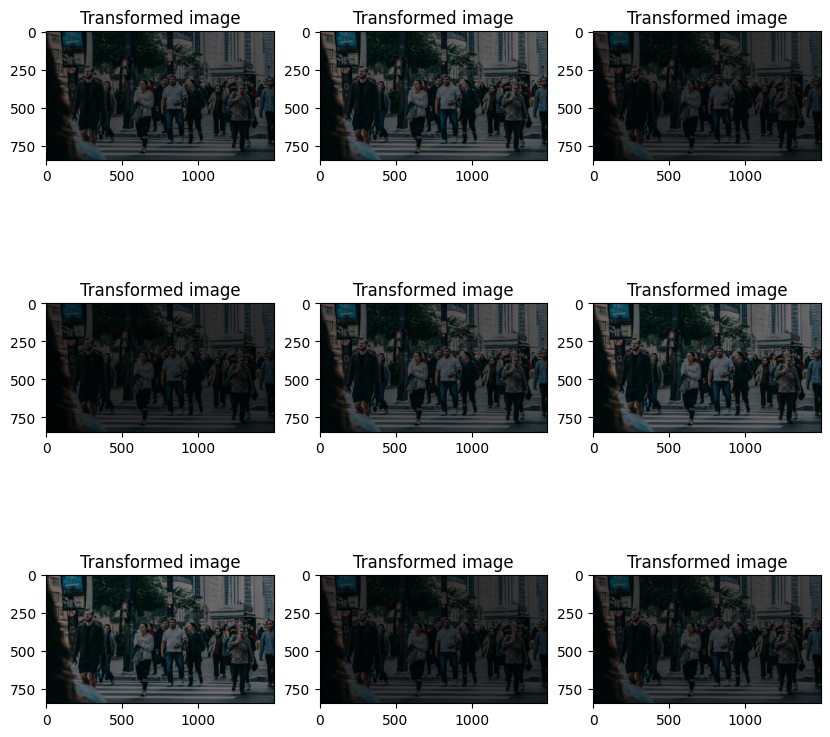

In [10]:
transforms = v2.Compose([
    custom_transform.RandomBrightness(
        brightness_factor=(0.2, 0.5),
        contrast_factor=1.
    ),
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True)
])

fig, axs = plt.subplots(3,3,figsize=(10,10))
axs = axs.ravel()
for i in range(9):
    axs[i].imshow(transforms(img).permute(1,2,0))
    axs[i].set_title("Transformed image")
plt.show()

In [11]:
logits = outputs.logits
bboxes = outputs.pred_boxes

bboxes.shape
target_sizes = torch.tensor([img.size[::-1]])
print(target_sizes)
results = image_processor.post_process_object_detection(outputs, threshold=0.9, target_sizes=target_sizes)[0]
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {model.config.id2label[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )

tensor([[ 844, 1500]])
Detected person with confidence 0.934 at location [1385.37, 320.07, 1499.47, 749.75]
Detected person with confidence 0.95 at location [694.37, 313.4, 856.65, 505.3]
Detected person with confidence 0.992 at location [881.13, 349.77, 1105.69, 716.96]
Detected person with confidence 0.956 at location [724.38, 323.56, 1020.64, 742.49]
Detected person with confidence 0.984 at location [519.39, 339.61, 826.49, 807.12]
Detected person with confidence 0.993 at location [149.21, 284.81, 484.34, 748.72]
Detected person with confidence 0.986 at location [1147.68, 400.67, 1432.28, 785.62]
Detected person with confidence 0.989 at location [1031.63, 378.83, 1237.35, 695.97]
Detected person with confidence 0.949 at location [1033.91, 347.83, 1146.76, 426.45]


In [ ]:
standard = v2.Compose([
    v2.ToImage(), 
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize((512, 1024))
])

test_transforms = [standard]

In [25]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using {device}")
model, image_processor = models.YOLOS()
model = model.to(device)

for transforms in test_transforms
    dataset = dl.DarkTestDataset("..\\data\\interim\\Dark", transforms=transforms)
    for img, points in dataset:
        outputs = model(img[None, :].to(device))
        logits = outputs.logits
        bboxes = outputs.pred_boxes

        target_sizes = torch.tensor([img.size()[1:]])
        results = image_processor.post_process_object_detection(outputs, threshold=0.9, target_sizes=target_sizes)[0]

        print(f"Prediction: {len(results['scores'])} people, Ground truth: {len(points)} people ({round(len(results['scores'])/len(points)*100.0, 3)}%)")
        print(f"Average confidence: {torch.mean(results['scores'])}", end="\n\n")


using cuda
Prediction: 4 people, Ground truth: 757 people (0.528%)
Average confidence: 0.9248107671737671

Prediction: 2 people, Ground truth: 284 people (0.704%)
Average confidence: 0.9564549326896667

Prediction: 4 people, Ground truth: 267 people (1.498%)
Average confidence: 0.9459041357040405

Prediction: 0 people, Ground truth: 197 people (0.0%)
Average confidence: nan

Prediction: 2 people, Ground truth: 696 people (0.287%)
Average confidence: 0.9614850282669067

Prediction: 4 people, Ground truth: 388 people (1.031%)
Average confidence: 0.9439619779586792

Prediction: 0 people, Ground truth: 121 people (0.0%)
Average confidence: nan

Prediction: 0 people, Ground truth: 119 people (0.0%)
Average confidence: nan

Prediction: 0 people, Ground truth: 1372 people (0.0%)
Average confidence: nan

Prediction: 1 people, Ground truth: 736 people (0.136%)
Average confidence: 0.9472306370735168

Prediction: 2 people, Ground truth: 168 people (1.19%)
Average confidence: 0.9130656719207764

P

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


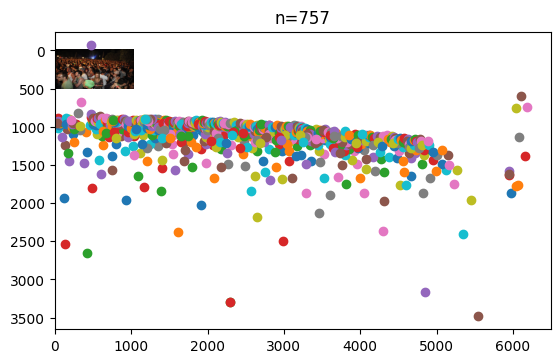

In [4]:
img, points = dataset[0]
plt.figure()
plt.imshow(img.permute(1,2,0))
for point in points:
    plt.plot(point[0], point[1], 'o')
plt.title(f"n={len(points)}")
plt.show()

In [25]:
for img, _ in dataset:
    print(img.shape)

torch.Size([3, 1325, 1987])
torch.Size([3, 688, 1024])
torch.Size([3, 1177, 1772])
torch.Size([3, 1936, 2592])
torch.Size([3, 1065, 1600])
torch.Size([3, 2448, 3264])
torch.Size([3, 900, 1200])
torch.Size([3, 1333, 2000])
torch.Size([3, 2304, 3456])
torch.Size([3, 960, 1440])
torch.Size([3, 1137, 2000])
torch.Size([3, 3744, 5616])
torch.Size([3, 2848, 4288])
torch.Size([3, 3744, 5616])
torch.Size([3, 2592, 3872])
torch.Size([3, 3456, 5184])
